In [2]:
# Use modules from parent directory
import os
import sys
import tifffile as tiff
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000   
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
from srcv2_2.models.params import get_params, HParams
from srcv2_2.models.Unet import Unet, UnetV2
from srcv2_2.models.UnetV3 import UnetV3
from srcv2_2.models.UnetV4_CXN import UnetV4_CXN
from srcv2_2.visualization.make_image_files import visualize_test_data, __visualize_landsat8_tile__
from srcv2_2.visualization.visualization_utils import get_predicted_thumbnails 
from srcv2_2.utils import get_model_name, predict_img_v2

import tensorflow as tf
import tensorflow.keras as keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-07-03 13:08:14.594446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 13:08:14.656022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 13:08:14.656116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from osgeo import gdal
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

In [4]:
day1 = "MOD09GA.A2023335.h18v04.061.2023340033530"

modis_tower_path = "/home/mxh/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_volume_path="/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_volume_path_2="/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"


## Load KERAS Model

In [5]:
#params = {"modelID": "dummy_240629081953", "project_path": "/home/mxh/RS-Net/", "random": False, "satellite": "MODIS"}
params = {"modelID": "dummy_240629081953-best-val-loss", "project_path": "/home/mxh/RS-Net/", "random": False, "satellite": "MODIS"}

hparams = HParams(**params)

#Loaded_params = UnetV4_CXN(params=hparams)._load_params()


#Loaded_params.update(**params)

#model = UnetV2(params=hparams)
model = UnetV4_CXN(params=hparams)

modelNick=U-net-v4-cxn-256-kernel77;plateau_patience=1;early_patience=100;modelID=dummy_240629081953-best-val-loss;random=False;shuffle=True;num_gpus=1;optimizer=AdamW;loss_func=sparse_categorical_crossentropy;activation_func=relu;last_layer_activation_func=softmax;initialization=glorot_normal;use_batch_norm=True;dropout_on_last_layer_only=True;early_stopping=True;lr_scheduler=True;reduce_lr=False;replace_fill_values=True;dataset_fill_cls=4;patience=12;save_best_only=True;use_ensemble_learning=False;ensemble_method=Bagging;learning_rate=1e-05;dropout=0.2;L1reg=0.0;L2reg=0.003;L1L2reg=0.0;decay=0.75;batch_norm_momentum=0.7;threshold=0.5;patch_size=256;overlap=40;overlap_train_set=60;batch_size=20;steps_per_epoch=None;epochs=42;norm_method=enhance_contrast;norm_threshold=65535;cls=['shadow', 'clear', 'thin', 'cloud'];collapse_cls=False;affine_transformation=True;brightness_augmentation=False;bands=[1, 2, 3, 4, 5, 6, 7];project_path=/home/mxh/RS-Net/;toa_path=data/processed/Biome_TOA/;dat

In [ ]:
# one of the hparam_opt models
params = get_params('U-net-v2', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-6
params.epochs = 5
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

params.modelID = "240415132825-CV2of2"

In [ ]:
local_loaded_model = tf.keras.saving.load_model(f"../models/Unet/{get_model_name(params)}.keras")
# weights and funcs will automatically be loaded

unet_loaded_local_model = UnetV2(params, model=local_loaded_model)

## Params

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# epochs 50
# lr 1e-6
# l2reg 1e-4
# dropout = 0
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-6
params.epochs = 8
params.threshold = 0.5
params.dropout = 0.0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1


params.overlap = 40
params.modelID = f"_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-{params.learning_rate}_L2reg-{params.L2reg}_dropout-{params.dropout}_epochs-{params.epochs}"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# epochs 50
# lr 1e-7
# l2reg 1e-4
# dropout = 0
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-7
params.epochs = 50
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1


params.overlap = 40
params.modelID = f"_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-{params.learning_rate}_L2reg-{params.L2reg}_dropout-{params.dropout}_epochs-{params.epochs}"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# epochs 8
# lr 1e-7
# l2reg 1e-4
# dropout = 0
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-7
params.epochs = 8
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = f"_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-{params.learning_rate}_L2reg-{params.L2reg}_dropout-{params.dropout}_epochs-{params.epochs}"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# epochs 5
# dropout = 0
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-7
params.epochs = 5
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-1e-7_L2-1e-4_dropout-0_epochs-5"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# epochs 20
# dropout = 0
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-7
params.epochs = 20
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-1e-7_L2-1e-4_dropout-0_epochs-20"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# lr 1e-6
# L2 1e-2
# dropout = 0.1
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-6
params.epochs = 5
params.threshold = 0.5
params.dropout = 0.1 # 0.2
params.dropout_on_last_layer_only = False
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-1e-6_L2-1e-4"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# lr 1e-6
# L2 1e-2
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-6
params.epochs = 5
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = False
params.L2reg = 1e-2
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-1e-6_L2-1e-2"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc


In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# lr 1e-5
# L2 1e-4
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-5
params.epochs = 5
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = False
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-1e-5_L2-1e-4"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V12 ######
######################################################################
# lr 1e-5
# L2 1e-2
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-5
params.epochs = 5
params.threshold = 0.5
params.dropout = 0 # 0.2
params.L2reg = 1e-2
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v11_lr-1e-2_L2-1e-2"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V11 ######
######################################################################
# L2 1e-4
# dropout 0.2
# epochs 10
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0.2
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v11_L2-1e-4_dropout-0.2"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V11 ######
######################################################################
# L2 1e-4
# epochs 10
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v11_L2-1e-4"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V11 ######
######################################################################
# L2 0
# epochs 10
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v11"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V10 ######
######################################################################
# 
# epochs 10
# threshold 16000 (for valid ranges)

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 10
params.threshold = 0.5
params.dropout = 0.1 # 0
params.L2reg = 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v10_threshold-16000-dropout0.1"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V9 ######
#####################################################################
# switched to elu
# epochs 20
# default threshold

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 20
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v9_threshold-default"
#params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V8 ######
#####################################################################
# switched to elu
# epochs 5
# test dropout=0.2, L2reg=0

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0.2
params.L2reg = 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v8_elu_dropout"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V8 ######
#####################################################################
# switched to elu
# epochs 5
# test dropout=0, L2reg=1e-4

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 1e-4 # 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v8_elu_l2reg"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V7 ######
#####################################################################
# switched to elu
# epochs 20

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 20
params.threshold = 0.5
params.dropout = 0.2 # 0
params.L2reg = 1e-4 # 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v7_elu"
params.norm_threshold = 3500


In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V6 ######
#####################################################################
# switched to elu
# reverted L2reg and dropout to 0

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v6_elu"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V5 ######
#####################################################################
# first with keras.metrics compilation

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='relu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0.2 # 0
params.L2reg = 1e-4 # 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v5"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V4 ######
#####################################################################

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='relu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0.2 # 0
params.L2reg = 1e-4 # 0
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v4"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth all layer softmax... V3 ######
#####################################################################

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='softmax' # 'relu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 10
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v3"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... V2 ######
#####################################################################

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='relu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v2"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V2 wth last layer softmax... ######
##########################

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
#params.activation_func='softmax'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax"
params.norm_threshold = 3500

In [ ]:
#### CLS MULTICLASS CTCS MODEL V1 ######
##########################

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='softmax'
params.loss="categorical_crossentropy"
params.learning_rate = 1e-4
params.epochs = 10
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_mc_cloud-thin-clear-shadow"
params.norm_threshold = 3500

In [ ]:
#### CLS CTCS MODEL ######
##########################

params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water'] 
#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='relu'
params.learning_rate = 1e-4
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_cls-cloud-thin-clear-shadow"
params.norm_threshold = 3500

In [ ]:
#### CLS HALF MODEL ######
##########################
params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'clear', 'shadow'] #'clear', 'cloud', 'shadow', 'snow', 'water']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu' # 'elu'
params.learning_rate = 1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_cls-cloud-clear-shadow"

params.norm_threshold = 3500

#params.norm_method = "running_normalization"

In [ ]:
#### CLS FULL MODEL ######
##########################
params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin', 'clear', 'shadow', 'snow', 'water'] #'clear', 'cloud', 'shadow', 'snow', 'water']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='relu' # 'elu'
params.learning_rate = 1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap = 40
params.modelID = "_v2_overlap40_cls-full"
params.norm_threshold = 3500

In [ ]:
training_params = get_params('U-net', 'MODIS')
training_params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
training_params.project_path = "/home/mxh/RS-Net/"
training_params.activation_func='relu'
training_params.learning_rate =1e-3
training_params.epochs = 5
training_params.threshold = 0.5
training_params.dropout = 0
training_params.L2reg = 0
training_params.decay = 0
training_params.num_gpus = 1
training_params.overlap=40
training_params.modelID = "_v2_overlap40_save-params"
training_params.norm_threshold = 3500

In [ ]:
params = get_params('U-net', 'MODIS')
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water

#testing with collapse=False
params.collapse_cls=True

params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu' # 'elu' in params
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.overlap=40
params.modelID = "_v2_overlap40"
params.norm_threshold = 3500

In [ ]:
params = get_params('U-net', 'Landsat8')
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu' #'relu'
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.modelID = "Test_Local"
params.norm_threshold = 3500

#tile = 'all'  # Name of one tile or 'all'
#tile = 'L2A_T32UNF_20170803T103019' 

## Predict

In [6]:
model.params.__dict__

{'modelID': 'dummy_240629081953-best-val-loss',
 'project_path': '/home/mxh/RS-Net/',
 'random': False,
 'satellite': 'Landsat8',
 'modelNick': 'U-net-v4-cxn-256-kernel77',
 'plateau_patience': 1,
 'early_patience': 100,
 'shuffle': True,
 'num_gpus': 1,
 'optimizer': 'AdamW',
 'loss_func': 'sparse_categorical_crossentropy',
 'activation_func': 'relu',
 'last_layer_activation_func': 'softmax',
 'initialization': 'glorot_normal',
 'use_batch_norm': True,
 'dropout_on_last_layer_only': True,
 'early_stopping': True,
 'lr_scheduler': True,
 'reduce_lr': False,
 'replace_fill_values': True,
 'dataset_fill_cls': 4,
 'patience': 12,
 'save_best_only': True,
 'use_ensemble_learning': False,
 'ensemble_method': 'Bagging',
 'learning_rate': 1e-05,
 'dropout': 0.2,
 'L1reg': 0.0,
 'L2reg': 0.003,
 'L1L2reg': 0.0,
 'decay': 0.75,
 'batch_norm_momentum': 0.7,
 'threshold': 0.5,
 'patch_size': 256,
 'overlap': 40,
 'overlap_train_set': 60,
 'batch_size': 20,
 'steps_per_epoch': None,
 'epochs': 42,

In [5]:
tf.keras.saving.get_custom_objects()

{'Custom>Adadelta': keras.src.optimizers.adadelta.Adadelta,
 'Custom>Adafactor': keras.src.optimizers.adafactor.Adafactor,
 'Custom>Adagrad': keras.src.optimizers.adagrad.Adagrad,
 'Custom>Adam': keras.src.optimizers.adam.Adam,
 'Custom>Adamax': keras.src.optimizers.adamax.Adamax,
 'Custom>AdamW': keras.src.optimizers.adamw.AdamW,
 'Custom>Ftrl': keras.src.optimizers.ftrl.Ftrl,
 'Custom>Lion': keras.src.optimizers.lion.Lion,
 'Custom>Nadam': keras.src.optimizers.nadam.Nadam,
 'Custom>RMSprop': keras.src.optimizers.rmsprop.RMSprop,
 'Custom>SGD': keras.src.optimizers.sgd.SGD,
 'Custom>CustomScaleLayer': keras.src.applications.inception_resnet_v2.CustomScaleLayer,
 'Custom>SharpnessAwareMinimization': keras.src.models.sharpness_aware_minimization.SharpnessAwareMinimization,
 'Custom>HParams': srcv2_2.models.params.HParams,
 'Custom>get_params': <function srcv2_2.models.params.get_params(model, satellite)>,
 'Custom>jaccard_coef': <function srcv2_2.models.model_utils.jaccard_coef(y_true, 

In [8]:
wpd = tiff.imread(modis_tower_path+day1+"_merged_2400_wgs84_warped.tiff")

In [9]:
wpd.min()
wpd.max()

16000

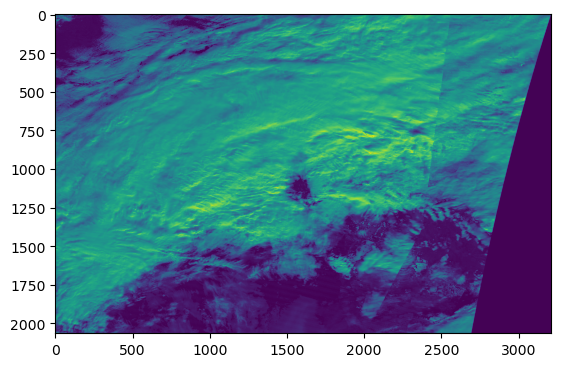

In [10]:
fig, ax = plt.subplots(1,1)
ax.imshow(wpd[:,:,0])

### Loading the files correctly (gdal, tifffile)

In [11]:


img_tiff_toa  = tiff.imread(modis_tower_path+day1+"_TOA_256.tiff")
img_gdal_toa = gdal.Open(modis_tower_path+day1+"_TOA_256.tiff").ReadAsArray()

img_gdal_merged = gdal.Open(modis_tower_path+day1+"_merged_256.tif")
img_tiff_merged  = tiff.imread(modis_tower_path+day1+"_merged_256.tif")

/home/mxh/anaconda3/envs/tf2+gpu/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [12]:
resized_img_tiff_toa = tf.image.resize(img_tiff_toa, (256,256))
resized_img_gdal_merged = tf.image.resize(img_gdal_merged.ReadAsArray(), (256,256))
resized_img_tiff_merged = tf.image.resize(img_tiff_merged, (256,256))

In [ ]:
fig, axes = plt.subplots(1,7, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_tiff_merged[:,:,i])
    #ax.imshow(resized_img_tiff_merged[i])

In [14]:
feed = np.expand_dims(img_tiff_merged, axis=0)
print(feed,"\n", feed.shape)

[[[[ 4799  4717  5097 ...  4350  3867  2338]
   [ 4437  4295  4867 ...  4026  3284  1825]
   [ 3123  2991  3638 ...  2919  2353  1547]
   ...
   [ 5460  5339  5258 ...  4429  2515  1478]
   [ 5632  5551  5427 ...  4703  2582  1552]
   [ 5849  5796  5679 ...  4918  2813  1664]]

  [[ 4032  3884  4215 ...  3815  3449  2285]
   [ 2774  2690  2965 ...  2718  2746  1969]
   [ 5245  5066  5449 ...  4714  3848  2116]
   ...
   [ 5723  5642  5548 ...  4752  2750  1699]
   [ 5254  5197  5178 ...  4362  2299  1399]
   [10676 10514 11180 ...  9074  5970  4287]]

  [[11378 11670 10303 ...  9904  7588  4369]
   [ 4611  4544  4748 ...  4194  3866  2589]
   [ 5795  5870  5868 ...  5341  4563  2678]
   ...
   [ 6126  5981  5931 ...  5054  2667  1497]
   [ 6649  6476  6453 ...  5436  2921  1760]
   [ 7743  7570  7501 ...  6478  3523  2116]]

  ...

  [[ 1622  2149  1671 ...  2166  1635  1040]
   [ 1552  2220  1570 ...  2307  1870  1415]
   [ 1337  2264  1181 ...  2509  2053  1319]
   ...
   [ 7600  739

In [15]:
res = model.predict(feed)

2024-06-06 22:05:55.594020: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800


1/1 [==============================] - 0s 451ms/step


In [16]:
res

array([[[[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        ...,

        [[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
 

### Color Mapping the Predictions:

In [19]:
from matplotlib.colors import ListedColormap

# 1. == cloud
# 0 == else

unet_color_code = {1.0: "white", 0.0: "black"}
unet_cmap = ListedColormap([unet_color_code[i] for i in range(2)])

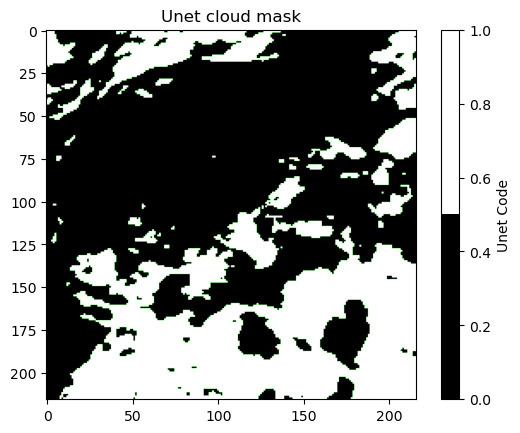

In [20]:
#fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.imshow(res[0], cmap=unet_cmap)
plt.colorbar(label="Unet Code")
plt.title("Unet cloud mask")
plt.show()

### Converting 3D array to tiff

In [21]:
def np_3D_array_to_tiff(output_path, np_array, projection, geo_transform, no_data_value=15):
    """
    Note: Filename has to end with .tiff (double f)
    """
    if output_path[-5:] != ".tiff":
        output_path += ".tiff"

    np_array[np.isnan(np_array)] = no_data_value

    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path, np_array.shape[2], np_array.shape[1], np_array.shape[0], gdal.GDT_Float32)
    # where np_array.shape(0) is band amount
    out_raster.SetProjection(projection)
    out_raster.SetGeoTransform(geo_transform)
    
    for i, b in enumerate(np_array):  # np_array has to be sorted (bands) in ascending order
        out_band = out_raster.GetRasterBand(i+1)  # Gdal Rasters start at index 1
        out_band.WriteArray(b)
        # out_band.SetNoDataValue(no_data_value)  # safe?
        out_band.FlushCache()
        out_band = None
    out_raster.FlushCache()
    out_raster = None

In [ ]:
np_3D_array_to_tiff(modis_tower_path+day1+"_predicted256_mask", res[0], img_gdal_merged.GetProjection(), img_gdal_merged.GetGeoTransform())

In [ ]:
pred_mask = gdal.Open(modis_tower_path+day1+"_predicted256_mask.tiff").ReadAsArray()
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.imshow(pred_mask)

In [ ]:
pred_mask

## Patch n Stitch

In [7]:
from srcv2_2.utils import patch_image, stitch_image, patch_v2, stitch_v2

In [ ]:
def patch_mod(img, patch_size=256, overlap=40):
    """
    Input:
    img: Shape = (width, height, depth)   (Note: Gdal probably supplies (depth, width, height) )

    Plan:
    I need to buffer every patch, not only the whole image. Buffer around all 4 edges with actual image data (if possible),
    not white noise, as I dont want to lose the information and the algo/model probably works better with more information.

    For the model i need:
    Therefore cut_size+buffer == 256 has to hold, as i need 7x256x256 images.
    Do i need to scale up to 256x256 on the edge-images? Yes
    #buffer2 = max(buffer, current_patch_size - cut_size) 

    This will probably result in worse results on the edges.

    cut_size > buffer!
    """
    cut_size = patch_size - 2*overlap  # buffer around all edges

    if cut_size <= overlap:
        raise ValueError("overlap < cut_size False")


    img_shape = np.shape(img)

    # Find number of patches
    n_width = int(np.ceil(int(img_shape[0]) / cut_size))
    n_height = int(np.ceil(int(img_shape[1]) / cut_size))

    # find rest 
    bufferx = int(max(overlap, n_width*cut_size-int(img_shape[0])))
    buffery = int(max(overlap, n_height*cut_size-int(img_shape[1])))

    print("buffer(x): " ,bufferx, "buffer(y): ", buffery)

    # prepare padded img of zeros
    img_padded = np.zeros((overlap + int(img_shape[0]) + bufferx, overlap + int(img_shape[1]) + buffery, int(img_shape[2])), dtype=img.dtype)
    img_padded[overlap:overlap + int(img_shape[0]), overlap:overlap + int(img_shape[1]), :] = img
    
    #patches = [[None] * n_height] * n_width
    img_patched = np.zeros((n_height * n_width, patch_size, patch_size, int(img_shape[2])), dtype=img.dtype)


    # cut patches
    for i in range(n_width):
        for j in range(n_height):
            id = n_height * i + j

            # patches[i][j] = img[i*cut_size-buffer:(i+1)*cut_size+buffer, j*cut_size-buffer:(j+1)*cut_size+buffer, :]
            xfrom = i*cut_size - min(i*overlap, overlap)
            xto = (i+1)*cut_size + (overlap*2 if i == 0 else overlap)   #+min((i+1)*buffer, buffer*2) #min(i*cut_size, buffer)
            yfrom = j*cut_size - min(j*overlap, overlap)
            yto = (j+1)*cut_size + (overlap*2 if j == 0 else overlap) #cut_size+min((j+1)*buffer, buffer*2) # min(j*cut_size, buffer)
            #patches[i][j] = img_padded[xfrom:xto, yfrom:yto, :]# 0:7]

            # Cut out the patches.
            # img_patched[id, width , height, depth]
            img_patched[id, :, :, :] = img_padded[xfrom:xto, yfrom:yto, :] #patches[i][j] # img_padded[xmin:xmax, ymin:ymax, :]

    return img_patched, img_shape, img.dtype, n_width, n_height



In [29]:
img_patched, og_shape, og_dtype, n_width, n_height = patch_v2(img=wpd, overlap=40, patch_size=256)

In [30]:
og_shape

(2064, 3211, 7)

In [25]:
#img_patched,  n_height, n_width = patch_image(img=wpd, overlap=40, patch_size=256)

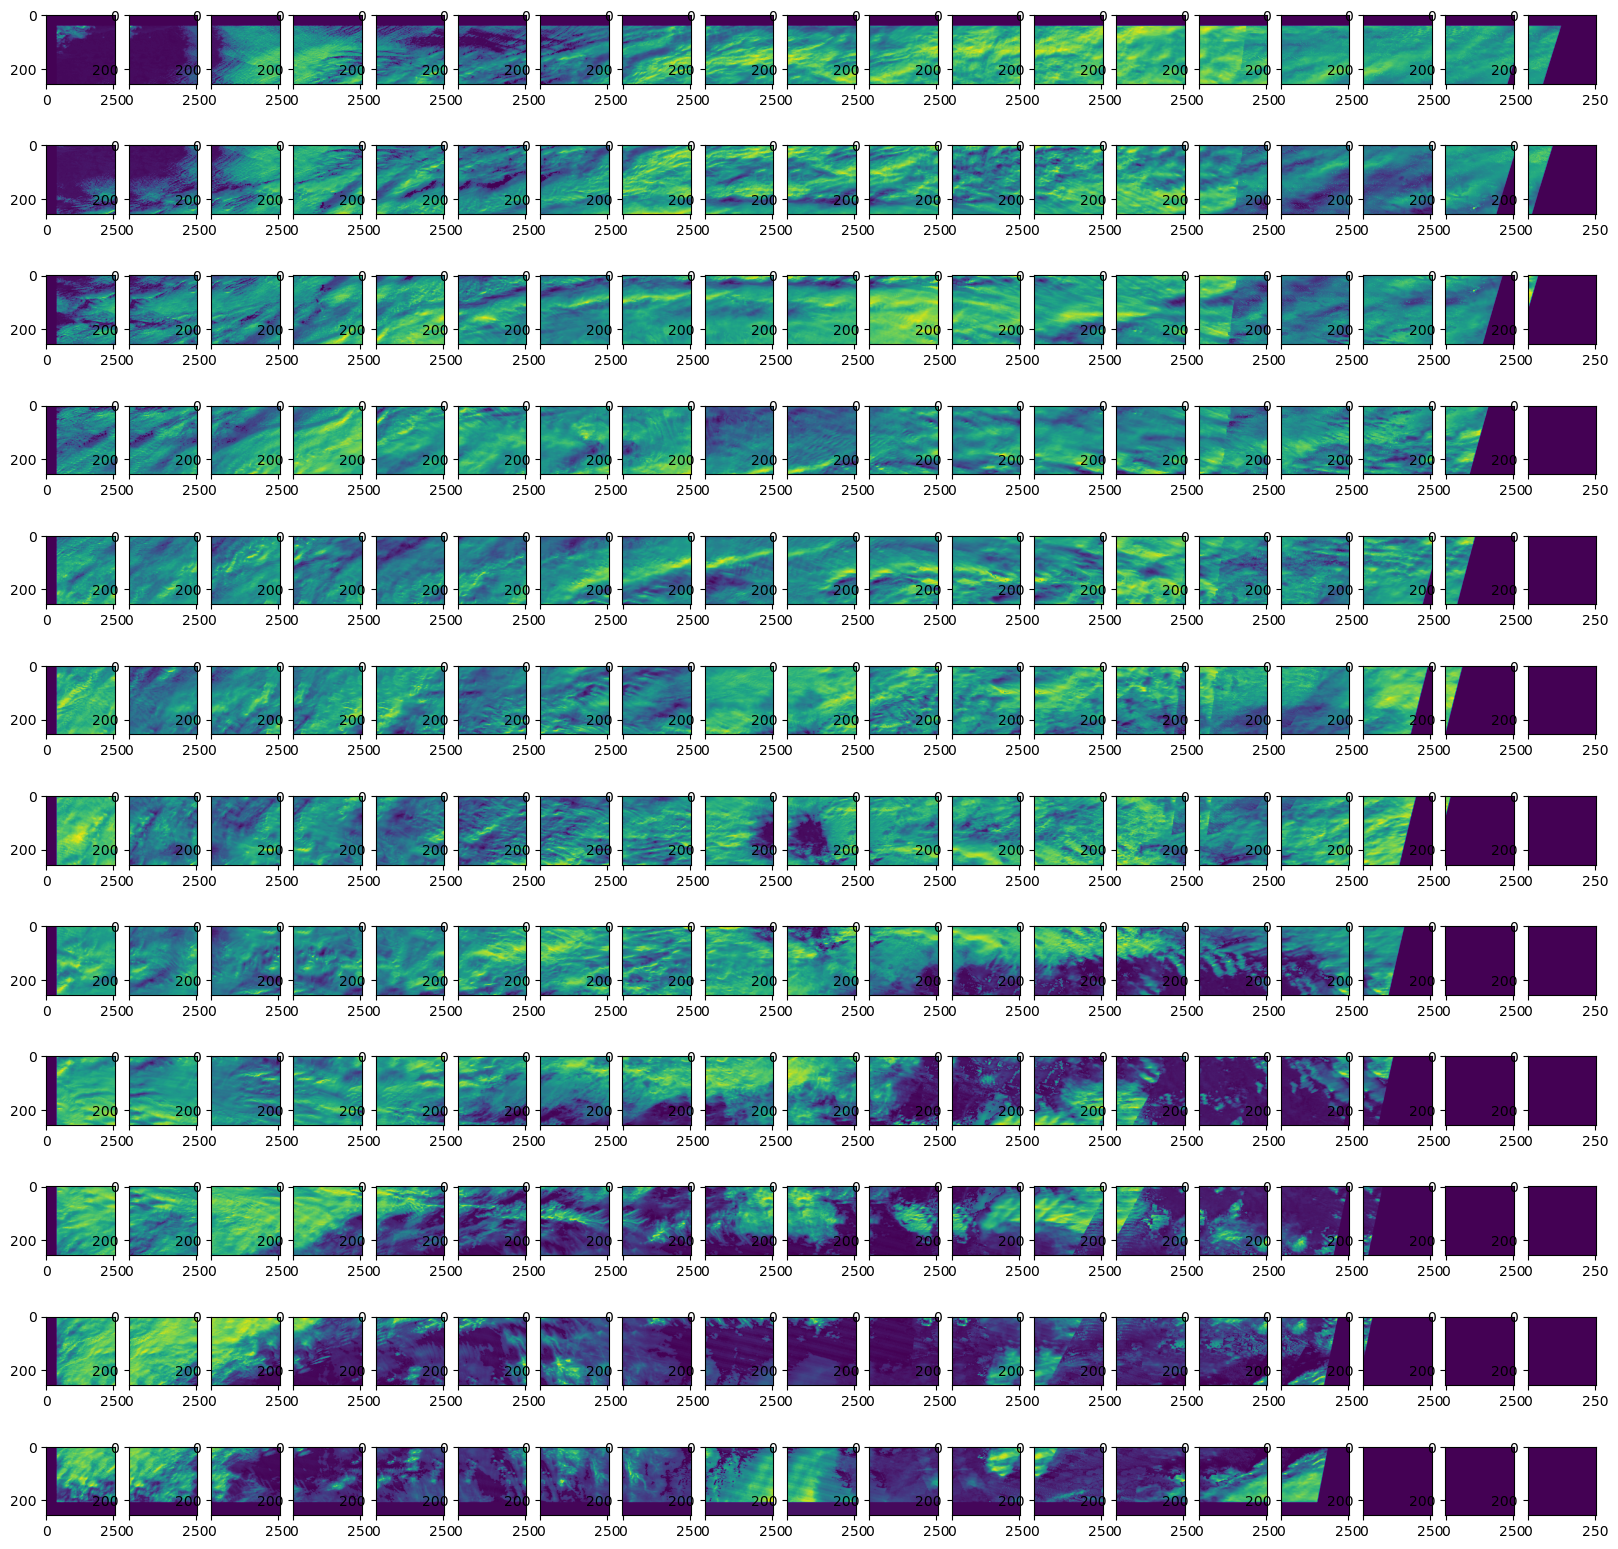

In [31]:
fig, axes = plt.subplots(n_width,n_height, figsize=(20,20))

for i, ax in enumerate(axes.flat):
    ax.imshow(img_patched[i][:,:,0])

In [ ]:
def stitch_mod(images, og_shape, og_dtype, patch_size=256, overlap=40):
    """
    images: (index_img, width, height, depth)
    og_shape: (width, height, depth)
    """
    cut_size = patch_size - 2*overlap 
    
    # Find number of patches
    n_width = int(np.ceil(int(og_shape[0]) / cut_size))
    n_height = int(np.ceil(int(og_shape[1]) / cut_size))

    # find rest 
    bufferx = int(max(overlap, n_width*cut_size-int(og_shape[0])))
    buffery = int(max(overlap, n_height*cut_size-int(og_shape[1])))
    
    # define image with bufferx and buffery to fit all patches. buffers will be omitted later
    img_stitched = np.zeros((og_shape[0]+bufferx, og_shape[1]+buffery, og_shape[2]), dtype=og_dtype)

    #for i, img in enumerate(images):
    for i in range(n_width):
        for j in range(n_height):
            id = n_height * i + j
            img_temp = np.zeros((cut_size, cut_size, og_shape[2]), dtype=og_dtype)
            img_temp = images[id][overlap:patch_size-overlap, overlap:patch_size-overlap, :]
            img_stitched[i*cut_size:(i+1)*cut_size, j*cut_size:(j+1)*cut_size,:] = img_temp

    return img_stitched[0:og_shape[0],0:og_shape[1],:]
        



In [32]:
#stitched_img = stitch_image(img_patched, n_height, n_width, patch_size=256, overlap=40)

In [33]:
stitched_img = stitch_v2(img_patched, og_shape, og_dtype)

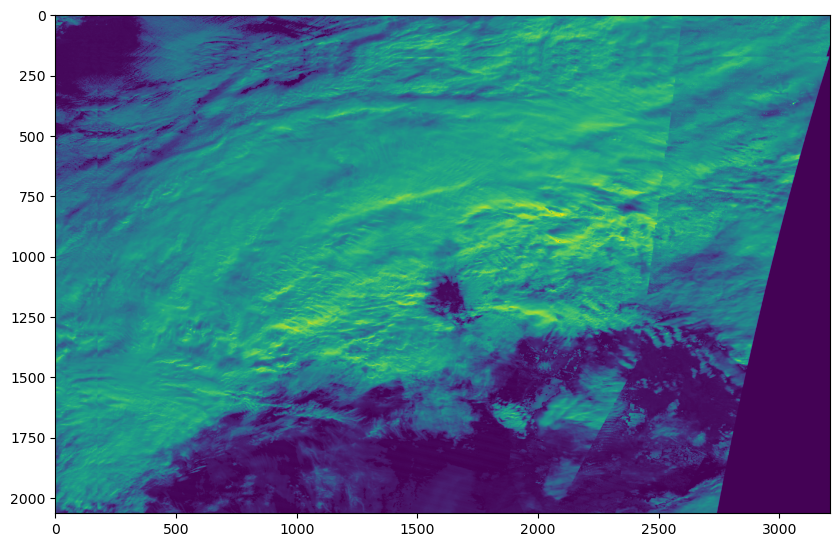

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(stitched_img[:,:,0])

## Predicting

In [8]:
# overlap is currently fixed to 40 for god knows why reasons
# training the model with param.overlap=10 or so might work
#params.overlap=40
n_cls = 4

In [5]:
pred = predict_img_v2(model, model.params, wpd, n_bands=7, n_cls=n_cls, num_gpus=1) # , patch_size=256, overlap=10)

NameError: name 'wpd' is not defined

In [37]:
non_binary_prediction = pred[0]
binary_prediction = pred[1]

In [38]:
non_binary_prediction[:,:,0] == non_binary_prediction[:,:,1] 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [39]:
non_binary_prediction

array([[[4.37534209e-06, 1.06017776e-02, 6.55858889e-02, 9.23807979e-01],
        [3.41314535e-06, 9.08679143e-03, 5.96097000e-02, 9.31300163e-01],
        [4.83850499e-06, 1.31336339e-02, 6.51155487e-02, 9.21746075e-01],
        ...,
        [1.30262947e-06, 3.75298481e-03, 1.96054336e-02, 9.76640224e-01],
        [2.92375518e-07, 1.66472967e-03, 1.28632924e-02, 9.85471666e-01],
        [1.33777959e-07, 1.07551762e-03, 9.83147789e-03, 9.89092827e-01]],

       [[1.03892180e-05, 1.43493982e-02, 9.09158960e-02, 8.94724369e-01],
        [1.78716243e-06, 4.04569134e-03, 5.72702661e-02, 9.38682258e-01],
        [6.24250731e-07, 2.24283966e-03, 4.44504768e-02, 9.53306079e-01],
        ...,
        [1.95157721e-08, 3.55697674e-04, 5.76173142e-03, 9.93882656e-01],
        [6.43933884e-09, 2.06456782e-04, 4.44818754e-03, 9.95345294e-01],
        [6.73017775e-09, 2.16311339e-04, 4.19564266e-03, 9.95587945e-01]],

       [[8.00362686e-05, 5.94491847e-02, 1.73688367e-01, 7.66782463e-01],
        

In [40]:
binary_prediction

array([[[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       [[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]],

       [[False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False, False]],

       ...,

       [[False,  True, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False,

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

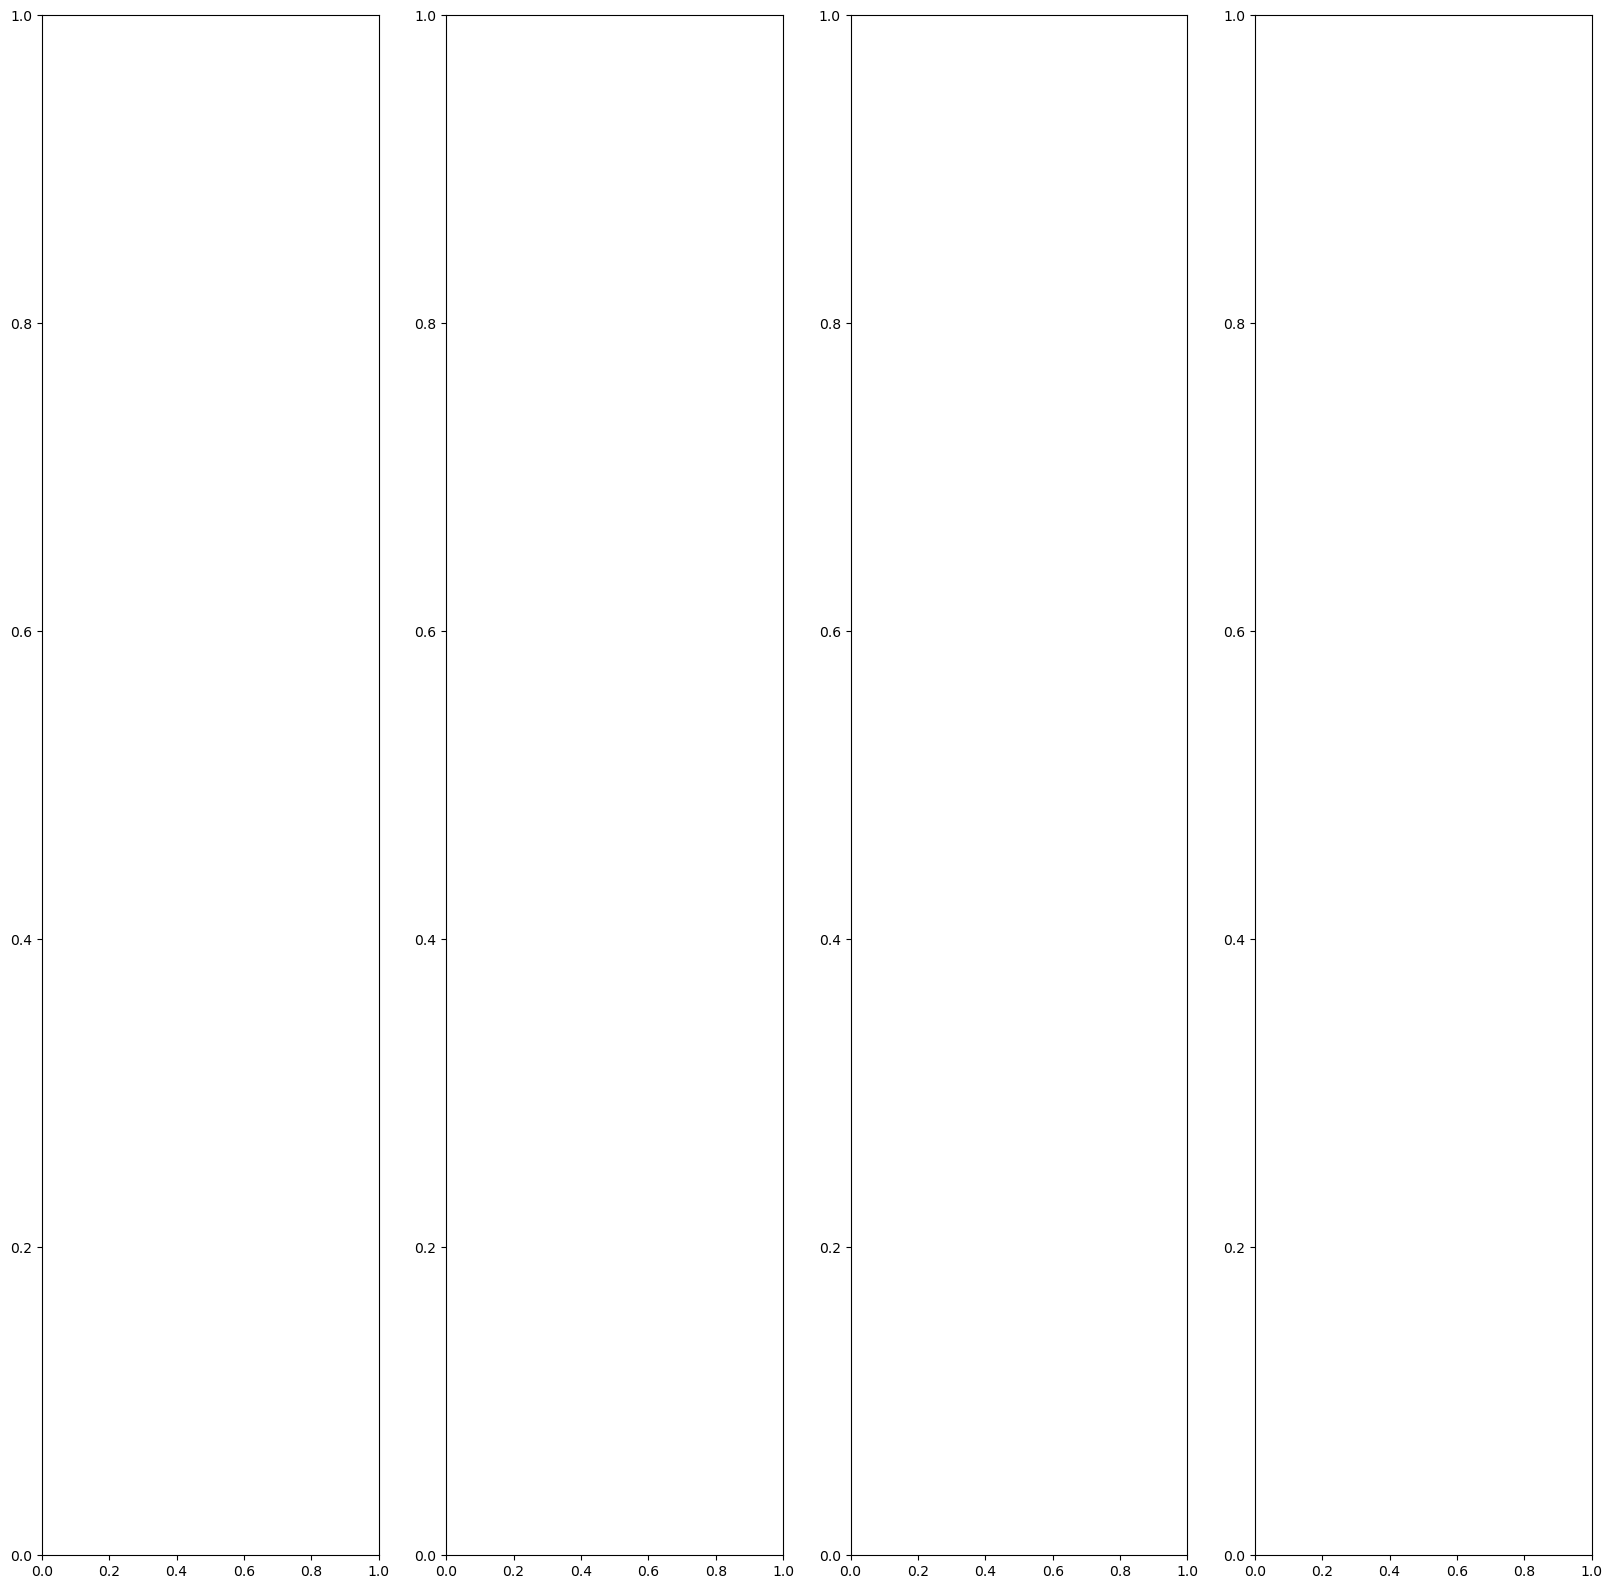

In [41]:
fig, ax = plt.subplots(1,n_cls, figsize=(20,20))
ax.imshow(binary_prediction[:,:,:])

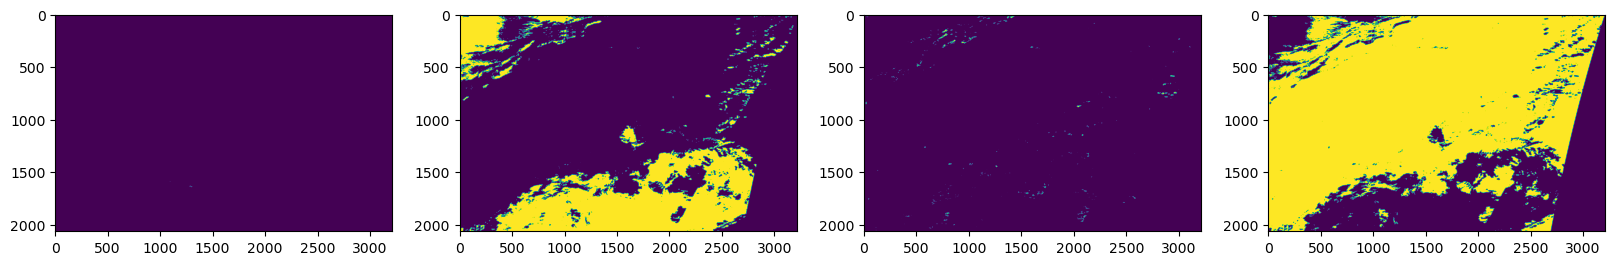

In [42]:
fig, axes = plt.subplots(1,n_cls, figsize=(20,20))

for i, ax in enumerate(axes.flat):
    ax.imshow(binary_prediction[:,:,i])

In [43]:
non_binary_prediction.shape

(2064, 3211, 4)

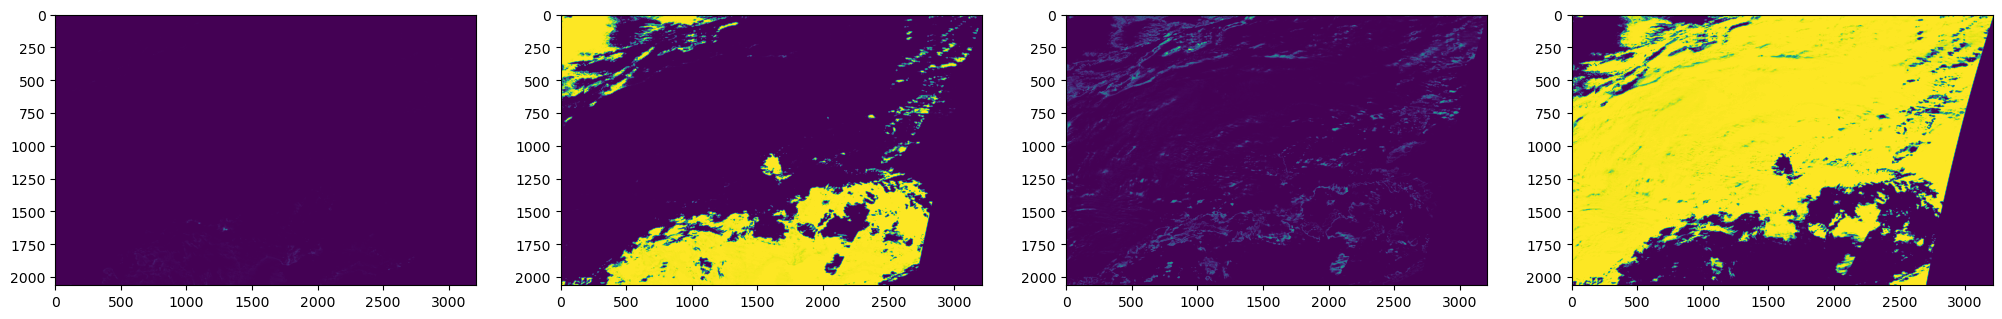

In [47]:
fig, axes = plt.subplots(1,n_cls, figsize=(25,25))

for i, ax in enumerate(axes.flat):
    ax.imshow(non_binary_prediction[:,:,i])

In [48]:
argmx = np.argmax(non_binary_prediction, axis=-1)


In [49]:
argmx

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [50]:
argmx.shape

(2064, 3211)

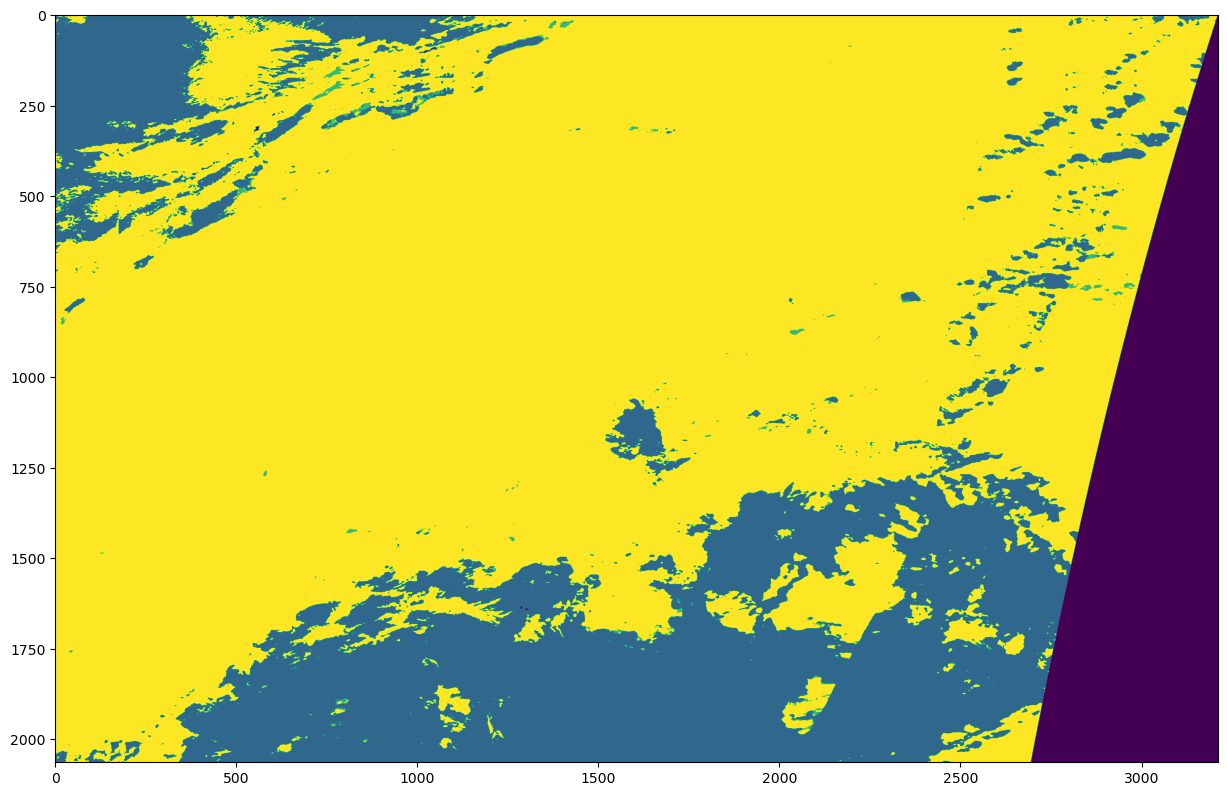

In [51]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

ax.imshow(argmx)

#### small check if info in 7 pred layers is redundant (it is if collapse_cls=True, else not so!)
and thus i'll just save one of the 7 layers to file without losing info

Codes i:
0: Prediction mask (all cls)
1: Binary mask (cloud, non-cloud)



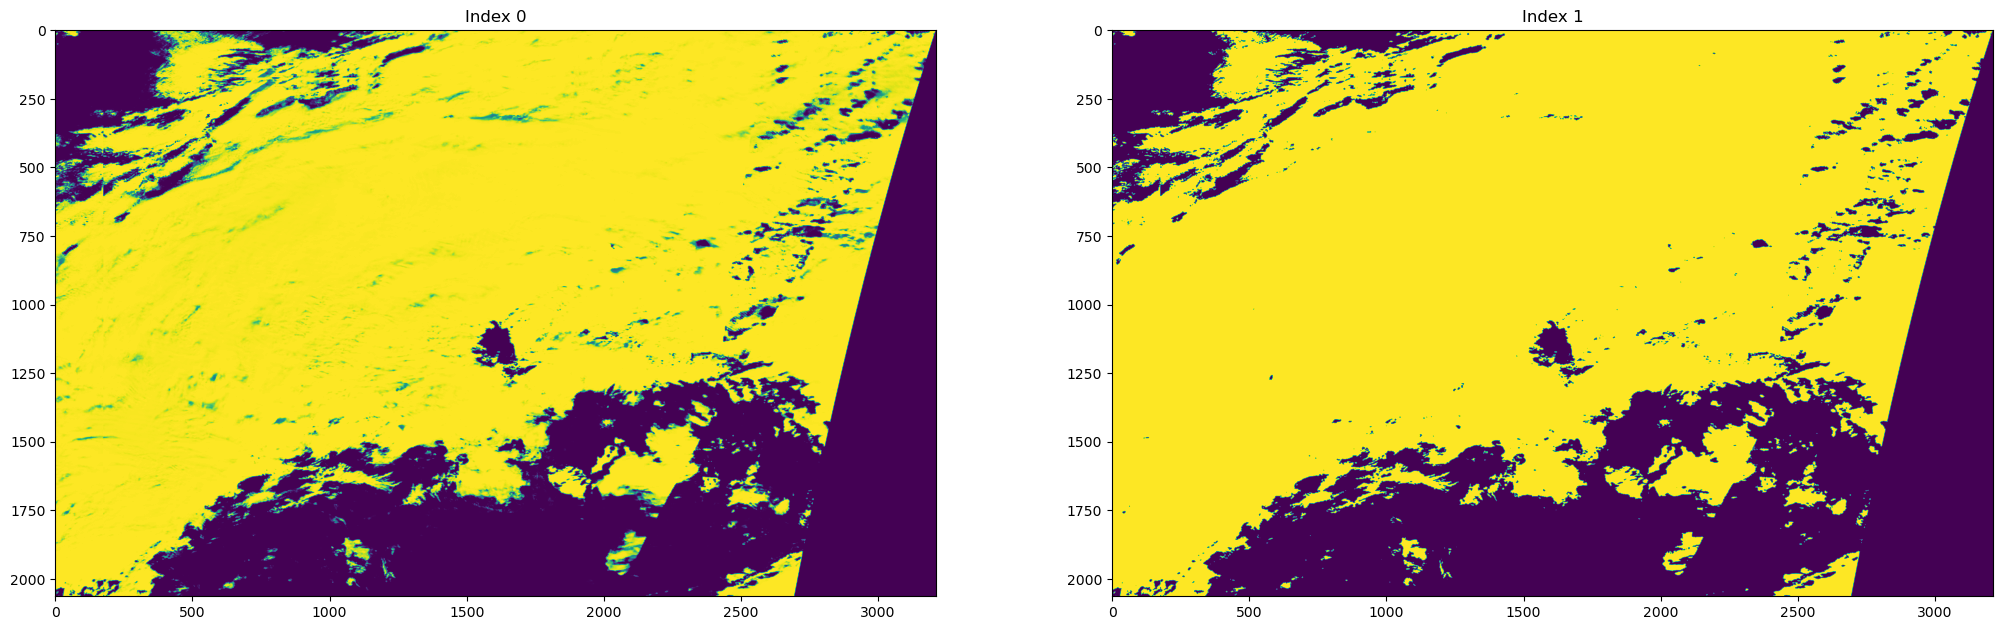

In [53]:
fig, axes = plt.subplots(1,2, figsize=(25,25))

print("""Codes i:
0: Prediction mask (all cls)
1: Binary mask (cloud, non-cloud)
""")

for i, ax in enumerate(axes.flat):
    ax.set(title=f"Index {i}")
    ax.imshow(pred[i][:,:,3])
    #ax.imshow(pred[i][:,:,0])

In [ ]:
pred

# Run Model on x-Day-Demo

In [10]:
curr_size=2400
modis_path = modis_tower_path
overlap = 40

In [11]:
days = {0: "MOD09GA.A2023335.h18v04.061.2023340033530.hdf",
1: "MOD09GA.A2023336.h18v04.061.2023338023416.hdf",
2: "MOD09GA.A2023337.h18v04.061.2023339023523.hdf",
3: "MOD09GA.A2023338.h18v04.061.2023340034455.hdf", 
4: "MOD09GA.A2023339.h18v04.061.2023341041457.hdf",
5: "MOD09GA.A2023340.h18v04.061.2023342030232.hdf",
6: "MOD09GA.A2023341.h18v04.061.2023343024753.hdf",
7: "MOD09GA.A2023342.h18v04.061.2023344024915.hdf",
8: "MOD09GA.A2023343.h18v04.061.2023345024918.hdf"}

In [12]:
days = {0: "MOD09GA.A2023335.h18v04.061.2023340033530.hdf",
1: "MOD09GA.A2023336.h18v04.061.2023338023416.hdf",
2: "MOD09GA.A2023337.h18v04.061.2023339023523.hdf",
3: "MOD09GA.A2023338.h18v04.061.2023340034455.hdf", 
4: "MOD09GA.A2023339.h18v04.061.2023341041457.hdf",
5: "MOD09GA.A2023340.h18v04.061.2023342030232.hdf",
6: "MOD09GA.A2023341.h18v04.061.2023343024753.hdf",
7: "MOD09GA.A2023342.h18v04.061.2023344024915.hdf",
8: "MOD09GA.A2023343.h18v04.061.2023345024918.hdf",
9: "MOD09GA.A2023344.h18v04.061.2023346030519.hdf",
10: "MOD09GA.A2023345.h18v04.061.2023347025532.hdf",
11: "MOD09GA.A2023346.h18v04.061.2023348030312.hdf",
12: "MOD09GA.A2023347.h18v04.061.2023349025736.hdf",
13: "MOD09GA.A2023348.h18v04.061.2023350024202.hdf",
14: "MOD09GA.A2023349.h18v04.061.2023351023935.hdf",
15: "MOD09GA.A2023350.h18v04.061.2023352030330.hdf",
16: "MOD09GA.A2023351.h18v04.061.2023353030525.hdf",
17: "MOD09GA.A2023352.h18v04.061.2023354042819.hdf",
18: "MOD09GA.A2023353.h18v04.061.2023355063849.hdf",
19: "MOD09GA.A2023354.h18v04.061.2023356042206.hdf",
20: "MOD09GA.A2023355.h18v04.061.2023357031321.hdf",
21: "MOD09GA.A2023356.h18v04.061.2023361000333.hdf",
22: "MOD09GA.A2023357.h18v04.061.2023359024858.hdf",
23: "MOD09GA.A2023358.h18v04.061.2023360025923.hdf",
24: "MOD09GA.A2023359.h18v04.061.2023361050233.hdf",
25: "MOD09GA.A2023360.h18v04.061.2023362134719.hdf",
26: "MOD09GA.A2023361.h18v04.061.2023363043955.hdf",
27: "MOD09GA.A2023362.h18v04.061.2023364042452.hdf",
28: "MOD09GA.A2023363.h18v04.061.2023365041515.hdf",
29: "MOD09GA.A2023364.h18v04.061.2024001025343.hdf",
30: "MOD09GA.A2023365.h18v04.061.2024004181336.hdf"
}

In [13]:
predictions = {}

In [14]:
for i, (k, filename) in enumerate(days.items()):
    day = modis_path + filename[:-4]
    # normal varant
    day += f"_merged_{curr_size}.tiff"
    
    # warped variant
    # day += f"_merged_{curr_size}_wgs84_warped.tiff"
    data = tiff.imread(day)
    pred_mask, pred_binary_mask = predict_img_v2(model, model.params, data, n_bands=7, n_cls=n_cls, num_gpus=model.params.num_gpus)
    predictions[k] = (pred_mask, pred_binary_mask)

2024-07-03 13:19:34.969672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800


3/3 [==============================] - 0s 128ms/step


In [14]:
predictions[0][0].shape

(2400, 2400, 4)

In [26]:
out = np.argmax(predictions[0][0], axis=-1)

In [28]:
out.max()

3

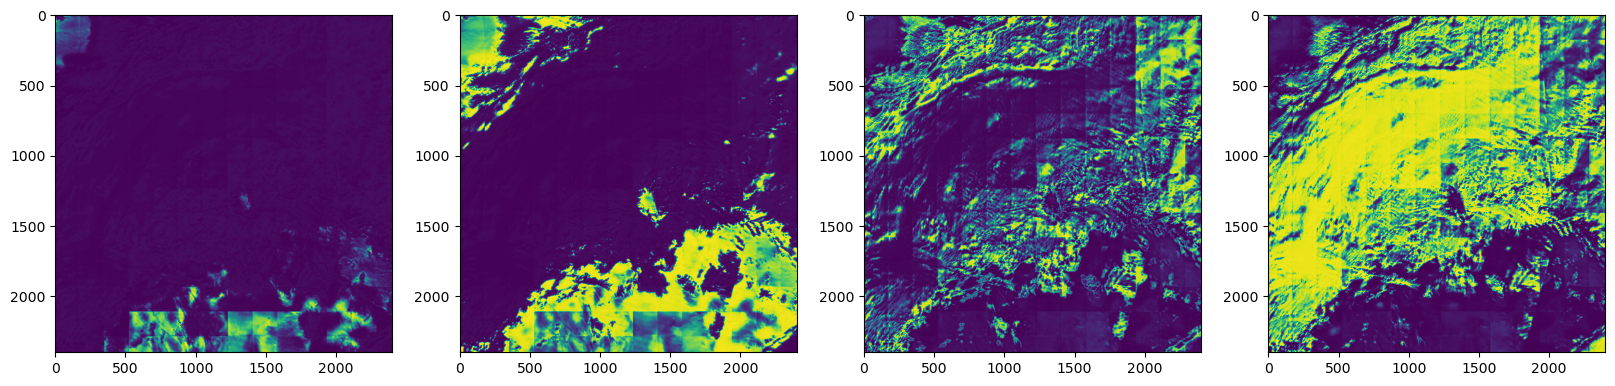

In [15]:
fig, axes = plt.subplots(1, n_cls, figsize=(20,20))

for i, ax in enumerate(axes.flat):
    ax.imshow(predictions[0][0][:,:,i])

In [16]:
# try to convert float output to int(to save it as readable for imagefusion...)
np.asarray(predictions[0][0], dtype=int)

#norrmalize to between 0and 255
image =  predictions[0][0].copy()
image *= (255.0/image.max())

# numpy convertequiv
npcast = image.astype('int32', casting='unsafe')  # maybe try uint8 aswell!!

In [17]:
npcast

array([[[  9,  66, 101,  78],
        [ 10,  34,  70, 139],
        [  7,  19,  53, 174],
        ...,
        [  8,  13, 154,  78],
        [  8,  12, 158,  76],
        [  8,  14, 144,  88]],

       [[  7, 110,  91,  46],
        [  9,  59,  99,  86],
        [  7,  31,  73, 143],
        ...,
        [  8,  13, 161,  72],
        [  7,  12, 168,  66],
        [  7,  16, 161,  70]],

       [[  6, 149,  69,  29],
        [  7,  88,  92,  66],
        [  7,  40,  92, 115],
        ...,
        [  8,  12, 154,  81],
        [  7,  12, 169,  65],
        [  8,  15, 167,  65]],

       ...,

       [[  1, 251,   2,   0],
        [  1, 250,   2,   0],
        [  1, 247,   5,   1],
        ...,
        [  3,   3,   4, 244],
        [  3,   2,   3, 245],
        [  3,   3,   4, 244]],

       [[  1, 250,   2,   0],
        [  1, 250,   3,   0],
        [  1, 244,   7,   1],
        ...,
        [  3,   2,   3, 246],
        [  3,   2,   4, 243],
        [  3,   2,   3, 245]],

       [[  1

In [18]:
image

array([[[  9.70548974,  66.16296265, 101.63654517,  78.10732642],
        [ 10.69727363,  34.5392162 ,  70.61805145, 139.75779985],
        [  7.72842091,  19.91489968,  53.22431443, 174.74470134],
        ...,
        [  8.33899565,  13.64085131, 154.67970353,  78.9527773 ],
        [  8.3693937 ,  12.8877639 , 158.00254496,  76.35263286],
        [  8.40329214,  14.80929961, 144.30889629,  88.09085023]],

       [[  7.19796301, 110.60495354,  91.70945434,  46.09996452],
        [  9.45676532,  59.72360523,  99.59195466,  86.84001592],
        [  7.68914475,  31.12419889,  73.01603361, 143.78297577],
        ...,
        [  8.14879911,  13.57945817, 161.58183339,  72.30224189],
        [  7.68500827,  12.69845197, 168.92625511,  66.3026053 ],
        [  7.99318946,  16.05199139, 161.08201159,  70.48512773]],

       [[  6.00615031, 149.88014357,  69.73916586,  29.98686662],
        [  7.84287136,  88.23232116,  92.69688654,  66.8402573 ],
        [  7.41928939,  40.05487228,  92.73620

In [19]:
# save predictions
cast_type='int8'
for i, (k, filename) in enumerate(days.items()):
    data = predictions[k]
    path = modis_path + filename[:-4]
    # normal variant
    path += f"_merged_{curr_size}_{model.params.modelID}_prediction"

    #warped variant
    #path += f"_merged_{curr_size}_wgs84_warped_{get_model_name(unet_loaded_local_model.params)}_prediction"
    #binmask_path = path + "_bin_mask.tiff"
    mask_path = path + "_"+cast_type+"_mask.tiff"

    #bin_mask = np.argmax(data[1], axis=-1)
    mask = np.argmax(data[0], axis=-1)

    tiff.imwrite(mask_path, data=mask.astype(cast_type, casting='unsafe'))
    #tiff.imwrite(binmask_path, data=bin_mask.astype(cast_type, casting='unsafe'))

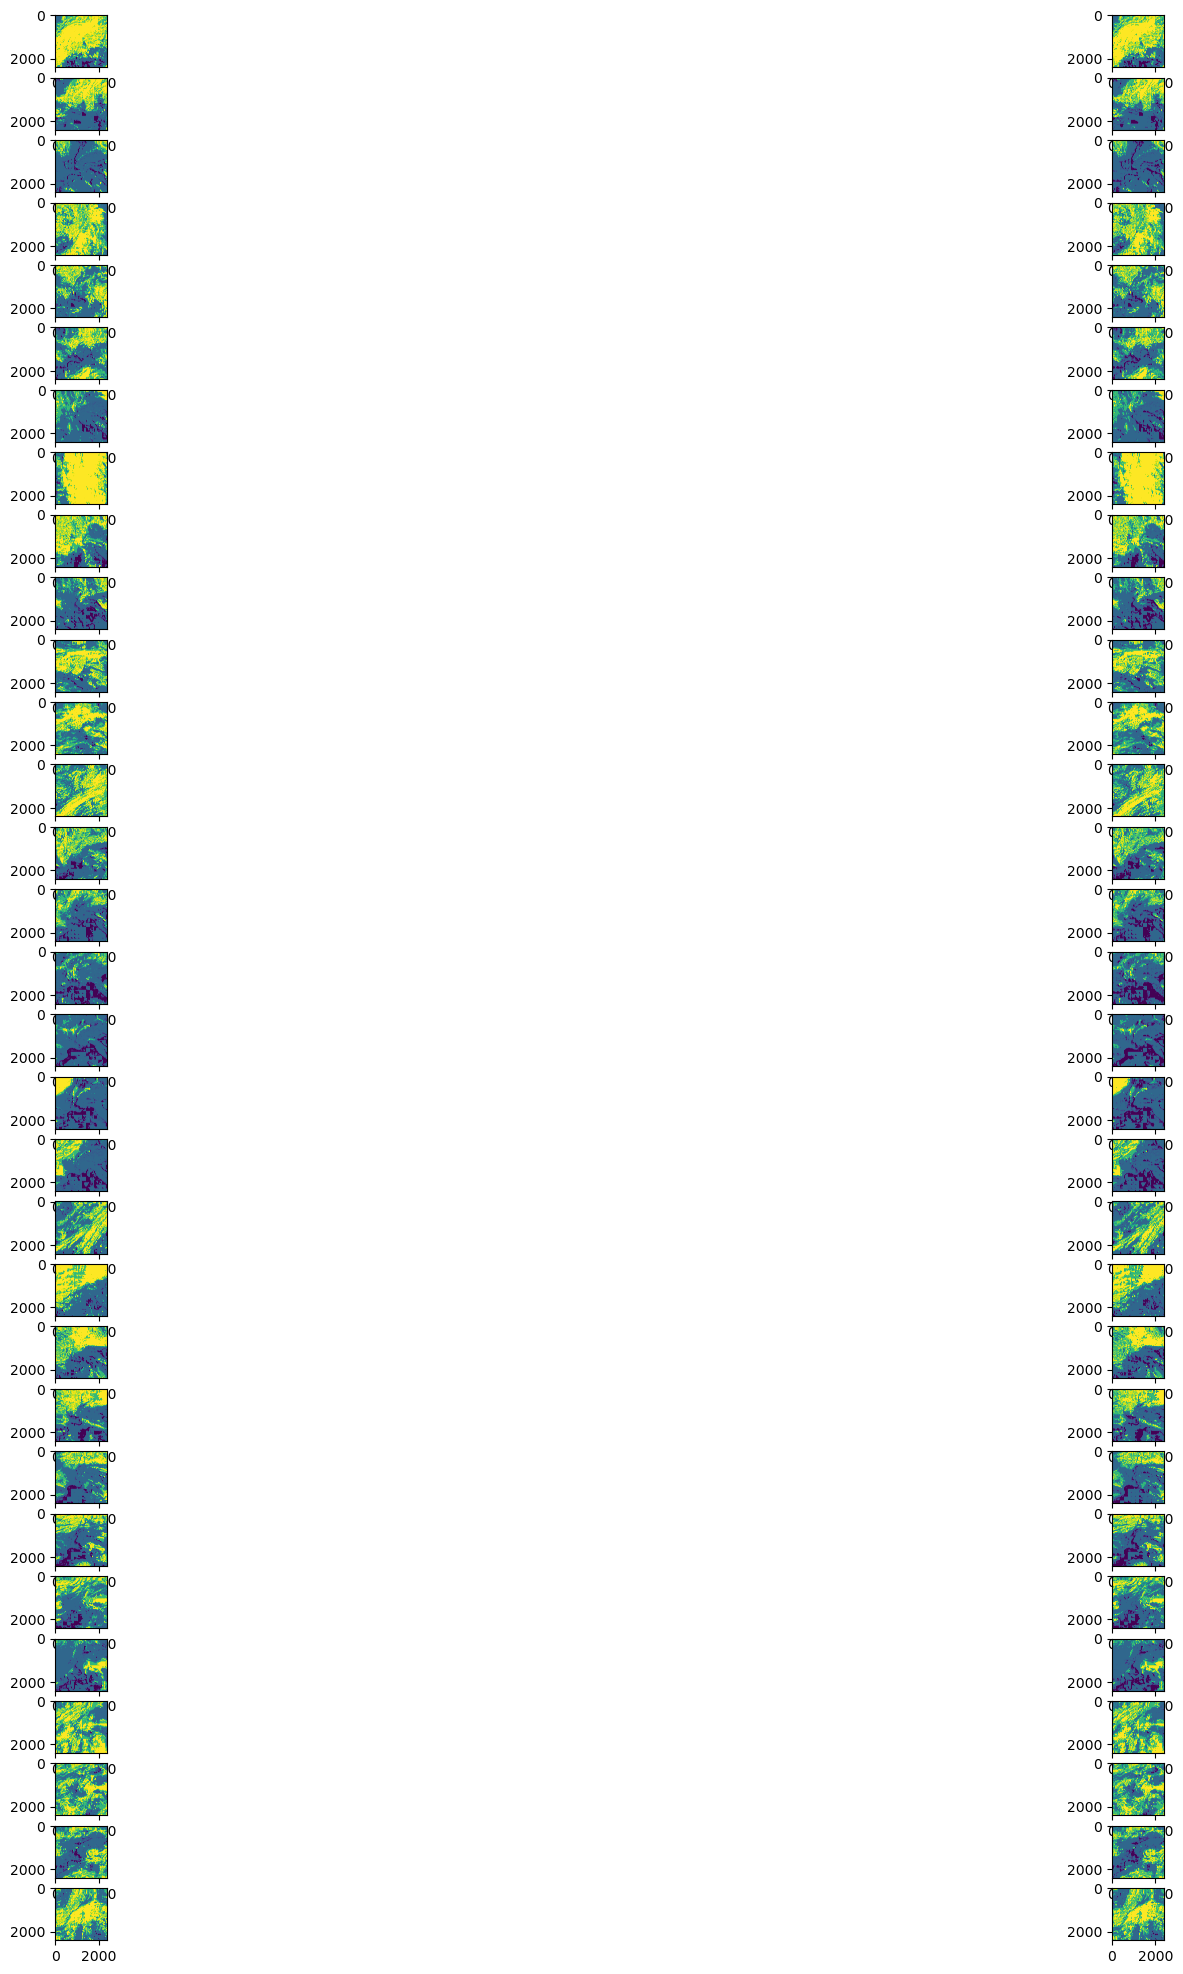

In [30]:
fig, axes = plt.subplots(len(days), 2, figsize=(25,25))
flat = axes.flat

i=-2
for k, filename in days.items():
    i += 2
    day = filename[:-4]
    day += f"_merged_{curr_size}"
    
    pred = tiff.imread(modis_path + day + f"_{model.params.modelID}_prediction_{cast_type}_mask.tiff")
    bin_pred = tiff.imread(modis_path + day + f"_{model.params.modelID}_prediction_bin_mask.tiff")
    flat[i].imshow(pred)
    flat[i+1].imshow(bin_pred)